# INTRODUCE
使用机器学习模型对数据进行分析，预测接下来比赛的结果。

In [66]:
import sys
print(sys.version)
# !pip list

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc, accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve

In [68]:
# 导入数据
df = pd.read_csv("./data/games.csv")
pd.set_option('display.max_columns', None)
# 数据格式修改并排序
df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])
df = df.sort_values(by='GAME_DATE_EST', ascending=False).reset_index(drop = True)
# 去除数据中的NaN
df = df.loc[df['SEASON'] >= 2004].reset_index(drop=True)
print("Whether the data contains NaN data:",df.isnull().values.any())
# 队伍名字替换ID
df_names = pd.read_csv('./data/teams.csv')
df_names = df_names[['TEAM_ID', 'NICKNAME']]
# 替换'HOME_TEAM_ID'
home_names = df_names.copy()
home_names.columns = ['HOME_TEAM_ID', 'NICKNAME']
result_1 = pd.merge(df['HOME_TEAM_ID'], home_names, how ="left", on="HOME_TEAM_ID")  
df['HOME_TEAM_ID'] = result_1['NICKNAME']
# 替换'VISITOR_TEAM_ID'
visitor_names = df_names.copy()
visitor_names.columns = ['VISITOR_TEAM_ID', 'NICKNAME']
result_2 = pd.merge(df['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
df['VISITOR_TEAM_ID'] = result_2['NICKNAME']
# 去掉'GAME_STATUS_TEXT','TEAM_ID_home','TEAM_ID_away'
df = df.drop(['GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away'], axis=1)
df.head()

Whether the data contains NaN data: False


,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Heat,Timberwolves,2021,104.0,0.398,0.760,0.333,23.0,53.0,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101009,Nuggets,Raptors,2021,115.0,0.551,0.750,0.407,32.0,39.0,127.0,0.471,0.760,0.387,28.0,50.0,0
2,2022-03-12,22101011,Trail Blazers,Wizards,2021,127.0,0.516,0.909,0.367,21.0,43.0,118.0,0.470,0.963,0.412,26.0,35.0,1
3,2022-03-12,22101010,Jazz,Kings,2021,134.0,0.558,0.710,0.390,21.0,44.0,125.0,0.500,0.857,0.394,27.0,33.0,1
4,2022-03-12,22101006,Bulls,Cavaliers,2021,101.0,0.443,0.933,0.429,20.0,46.0,91.0,0.419,0.824,0.208,19.0,40.0,1


# Figure

In [69]:
# 变量分析和统计信息
# df.profile_report()

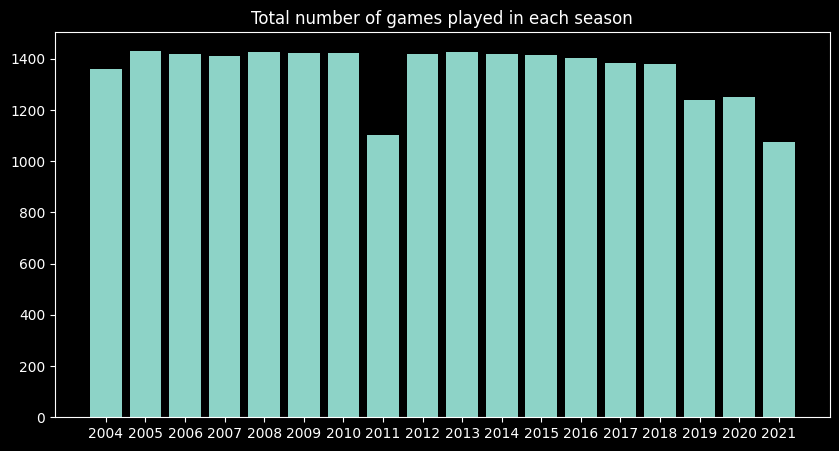

In [70]:
# 每个赛季的比赛情况
fig, ax = plt.subplots(figsize=(10,5))
v_c = df['SEASON'].value_counts().sort_index()
v_c.index = v_c.index.astype(str)
ax.bar(v_c.index, v_c.values)
plt.title("Total number of games played in each season")
plt.show()

,EQUIPO,VICTORIAS
0,Spurs,1101
1,Heat,985
2,Celtics,971
3,Mavericks,945
4,Warriors,942


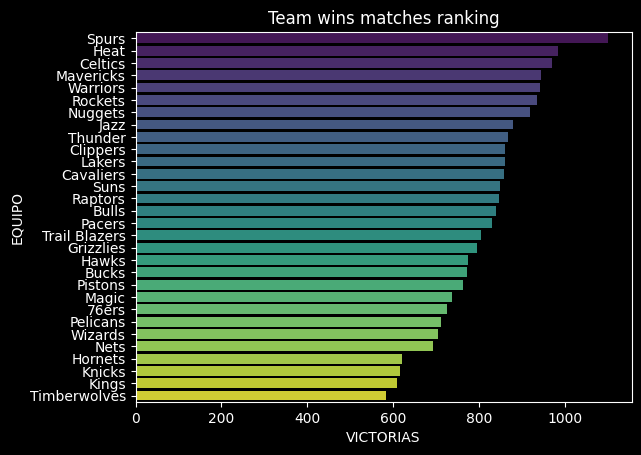

In [71]:
# 数据中全部队伍的胜场排名
top_win = np.where(df['HOME_TEAM_WINS'] == 1, df['HOME_TEAM_ID'], df['VISITOR_TEAM_ID'])
top_win = pd.DataFrame(top_win, columns=['TEAM_ID'])
top_win = top_win.value_counts().to_frame().reset_index()
top_win.columns = ['EQUIPO', 'VICTORIAS']
tw = sns.barplot(data=top_win, x='VICTORIAS', y='EQUIPO', palette = 'viridis').set(title='Team wins matches ranking')
top_win.head()

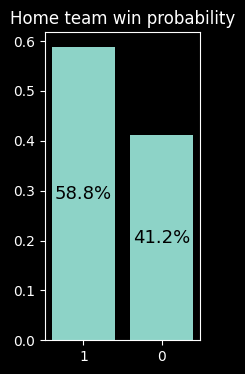

In [72]:
# 主队胜率
fig, ax = plt.subplots(figsize=(2,4))
v_c = df['HOME_TEAM_WINS'].value_counts(normalize=True)
v_c.index = v_c.index.astype(str)
ax.bar(v_c.index, v_c.values, 0.8)
for i in ax.patches:
    x, y = i.get_x(), i.get_y()
    w, h = i.get_width(), i.get_height()

    val = str(round(h*100,1)) + '%' 

    ax.text(x + w/2, y + h/2, val,
            horizontalalignment='center', verticalalignment='center',
            fontsize=13, color='black')
plt.title("Home team win probability")
plt.show()

,EQUIPO,PTS EN CASA,PTS FUERA DE CASA,PTS TOTALES
1,Warriors,90857.0,88331.0,179188.0
2,Spurs,90219.0,86600.0,176819.0
6,Nuggets,87370.0,87519.0,174889.0
4,Celtics,88841.0,85864.0,174705.0
3,Heat,89094.0,84666.0,173760.0


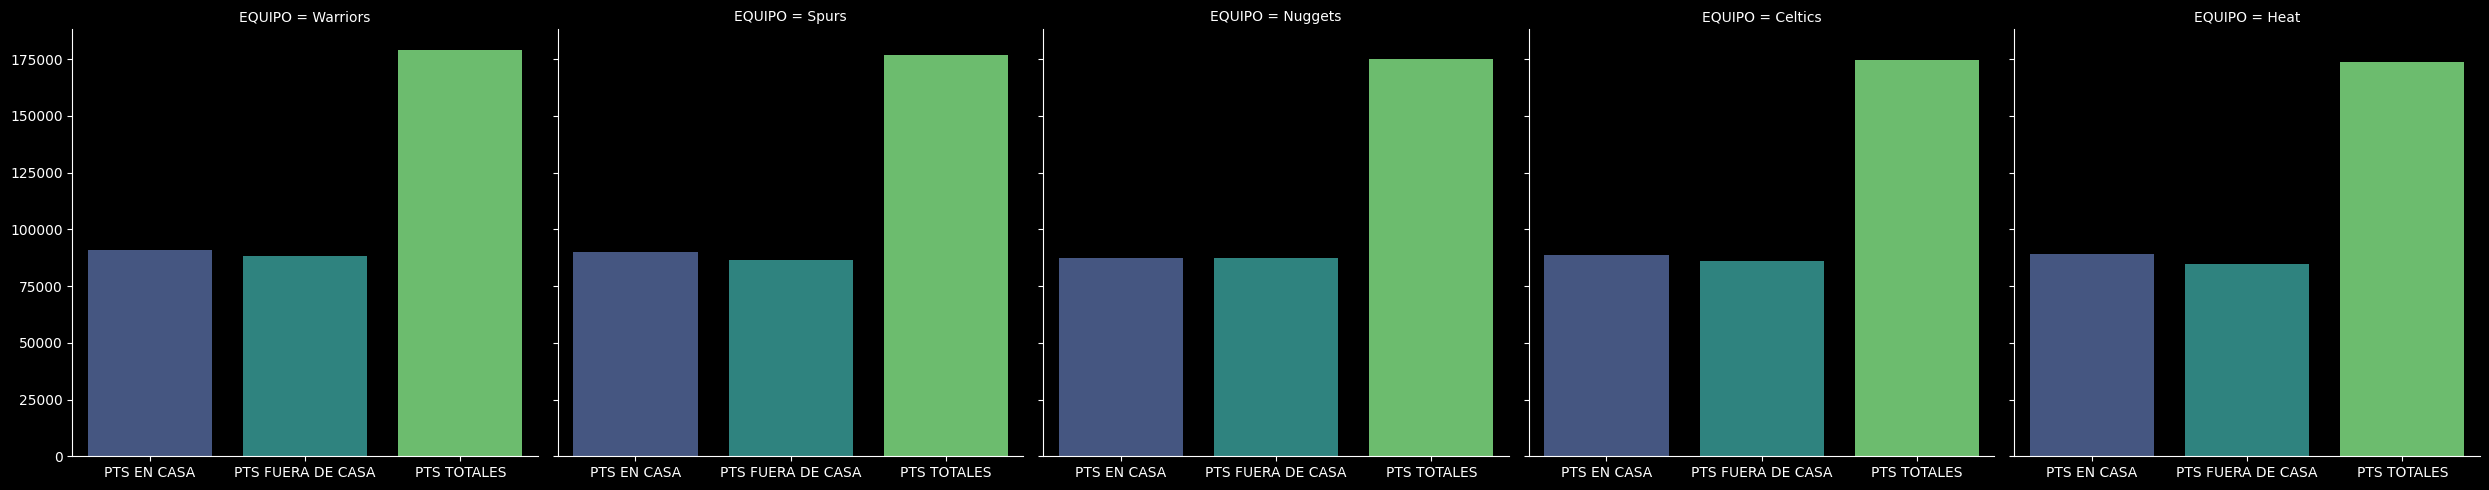

In [73]:
# 主场得分最多的主队排名
teamhome_pts = df.groupby(['HOME_TEAM_ID']).agg({'PTS_home':sum}).sort_values(['PTS_home'],ascending=False).reset_index()
teamhome_pts.columns = ['EQUIPO', 'PTS']

# 客场得分最多的客队排名
teamvisitor_pts = df.groupby(['VISITOR_TEAM_ID']).agg({'PTS_away':sum}).sort_values(['PTS_away'],ascending=False).reset_index()
teamvisitor_pts.columns = ['EQUIPO', 'PTS']

# 得分最多的球队排名
team_pts = teamhome_pts.merge(teamvisitor_pts[['EQUIPO','PTS']], on='EQUIPO')
team_pts['PTS TOTALES'] = team_pts.sum(axis=1)
team_pts.columns = ['EQUIPO', 'PTS EN CASA', 'PTS FUERA DE CASA', 'PTS TOTALES']
team_pts = team_pts.sort_values(['PTS TOTALES'],ascending=False)

sns.catplot(data=team_pts[0:5], col='EQUIPO', kind='bar', palette='viridis')
team_pts.head()

,EQUIPO,AST EN CASA,AST FUERA DE CASA,ASISTENCIAS TOTALES
0,Warriors,21747.0,19475.0,41222.0
2,Spurs,20814.0,18851.0,39665.0
3,Celtics,20558.0,18630.0,39188.0
4,Nuggets,20465.0,18719.0,39184.0
10,Suns,18829.0,19013.0,37842.0


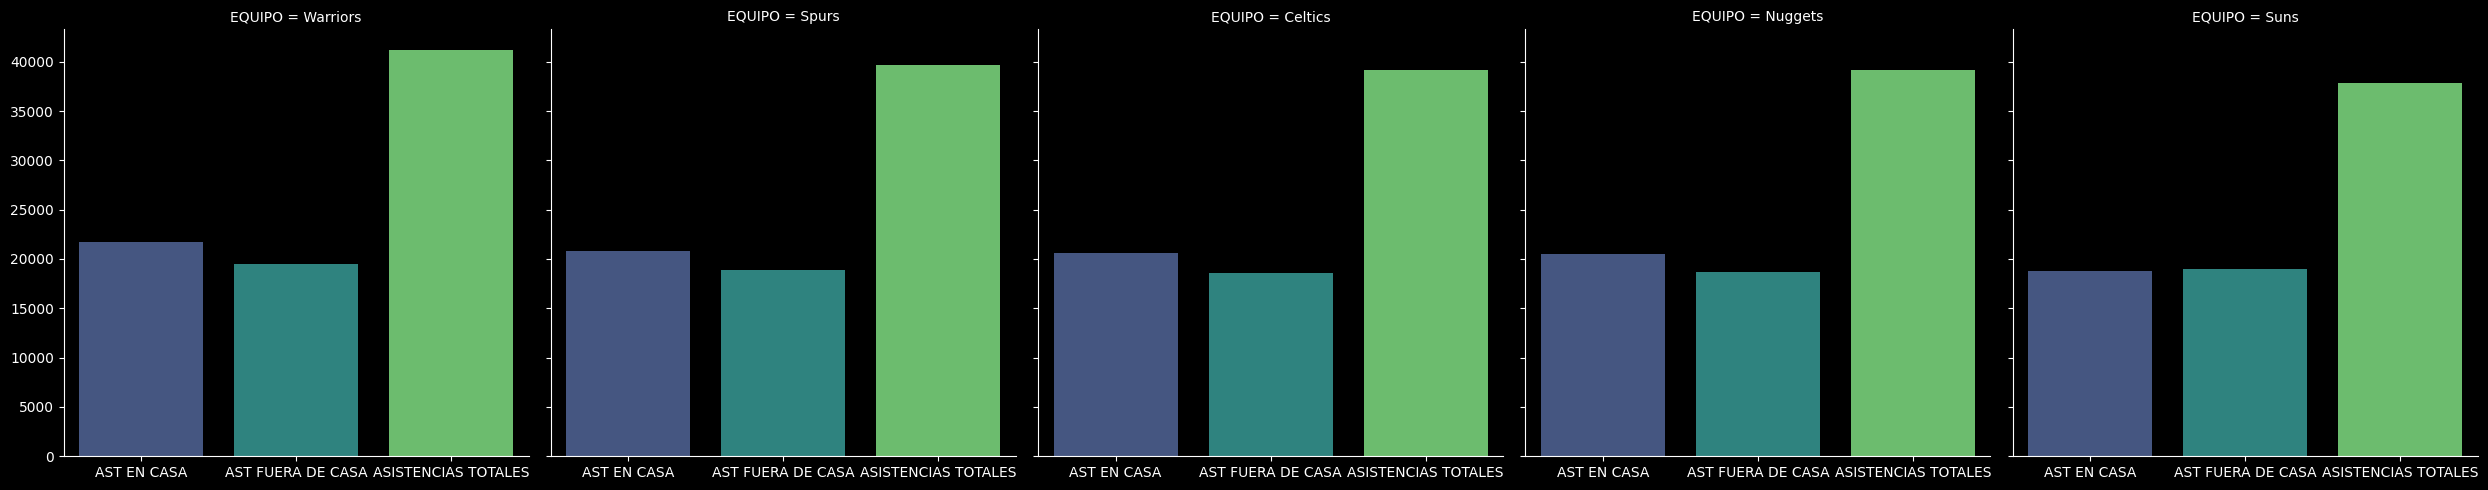

In [74]:
# 主场得分最多的主队排名
teamhome_ast = df.groupby(['HOME_TEAM_ID']).agg({'AST_home':sum}).sort_values(['AST_home'],ascending=False).reset_index()
teamhome_ast.columns = ['EQUIPO', 'ASISTENCIAS']

# 客场助攻最多的客队排名
teamvisitor_ast = df.groupby(['VISITOR_TEAM_ID']).agg({'AST_away':sum}).sort_values(['AST_away'],ascending=False).reset_index()
teamvisitor_ast.columns = ['EQUIPO', 'ASISTENCIAS']

# 助攻最多的球队排名
team_ast = teamhome_ast.merge(teamvisitor_ast[['EQUIPO','ASISTENCIAS']], on='EQUIPO')
team_ast['ASISTENCIAS TOTALES'] = team_ast.sum(axis=1)
team_ast.columns = ['EQUIPO', 'AST EN CASA', 'AST FUERA DE CASA', 'ASISTENCIAS TOTALES']
team_ast = team_ast.sort_values(['ASISTENCIAS TOTALES'],ascending=False)

sns.catplot(data=team_ast[0:5], col='EQUIPO', kind='bar', palette='viridis')
team_ast.head()

,EQUIPO,REB EN CASA,REB FUERA DE CASA,REBOTES TOTALES
0,Lakers,39349.0,33836.0,82444.0
2,Spurs,37363.0,36338.0,79330.0
3,Cavaliers,36988.0,34684.0,78376.0
4,Celtics,36822.0,35497.0,78368.0
10,Nuggets,35900.0,36139.0,75684.0


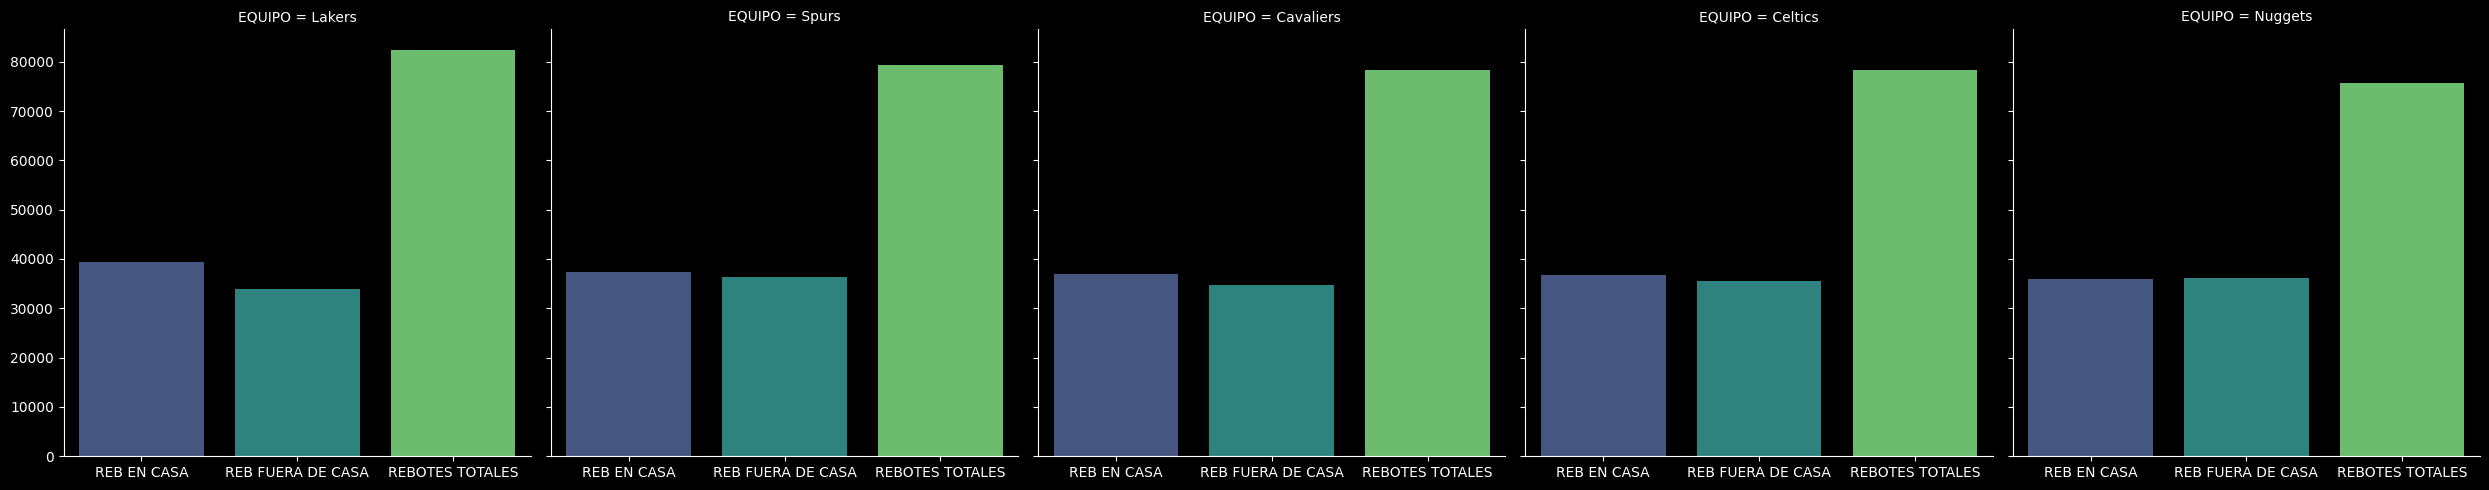

In [75]:
# 主场篮板最多的主队
teamhome_reb = df.groupby(['HOME_TEAM_ID']).agg({'REB_home':sum}).sort_values(['REB_home'],ascending=False).reset_index()
teamhome_reb.columns = ['EQUIPO', 'REBOTES']
# 客场篮板最多的客队
teamvisitor_reb = df.groupby(['VISITOR_TEAM_ID']).agg({'REB_away':sum}).sort_values(['REB_away'],ascending=False).reset_index()
teamvisitor_reb.columns = ['EQUIPO', 'REBOTES']
# 篮板最多的球队排名
team_reb = teamhome_reb.merge(teamvisitor_reb[['EQUIPO','REBOTES']], on='EQUIPO')
team_reb['REBOTES TOTALES'] = team_ast.sum(axis=1)
team_reb.columns = ['EQUIPO', 'REB EN CASA', 'REB FUERA DE CASA', 'REBOTES TOTALES']
team_reb = team_reb.sort_values(['REBOTES TOTALES'],ascending=False)

sns.catplot(data=team_reb[0:5], col="EQUIPO", kind="bar", palette = 'viridis')
team_reb.head()

<AxesSubplot:title={'center':'Correlation matrix'}>

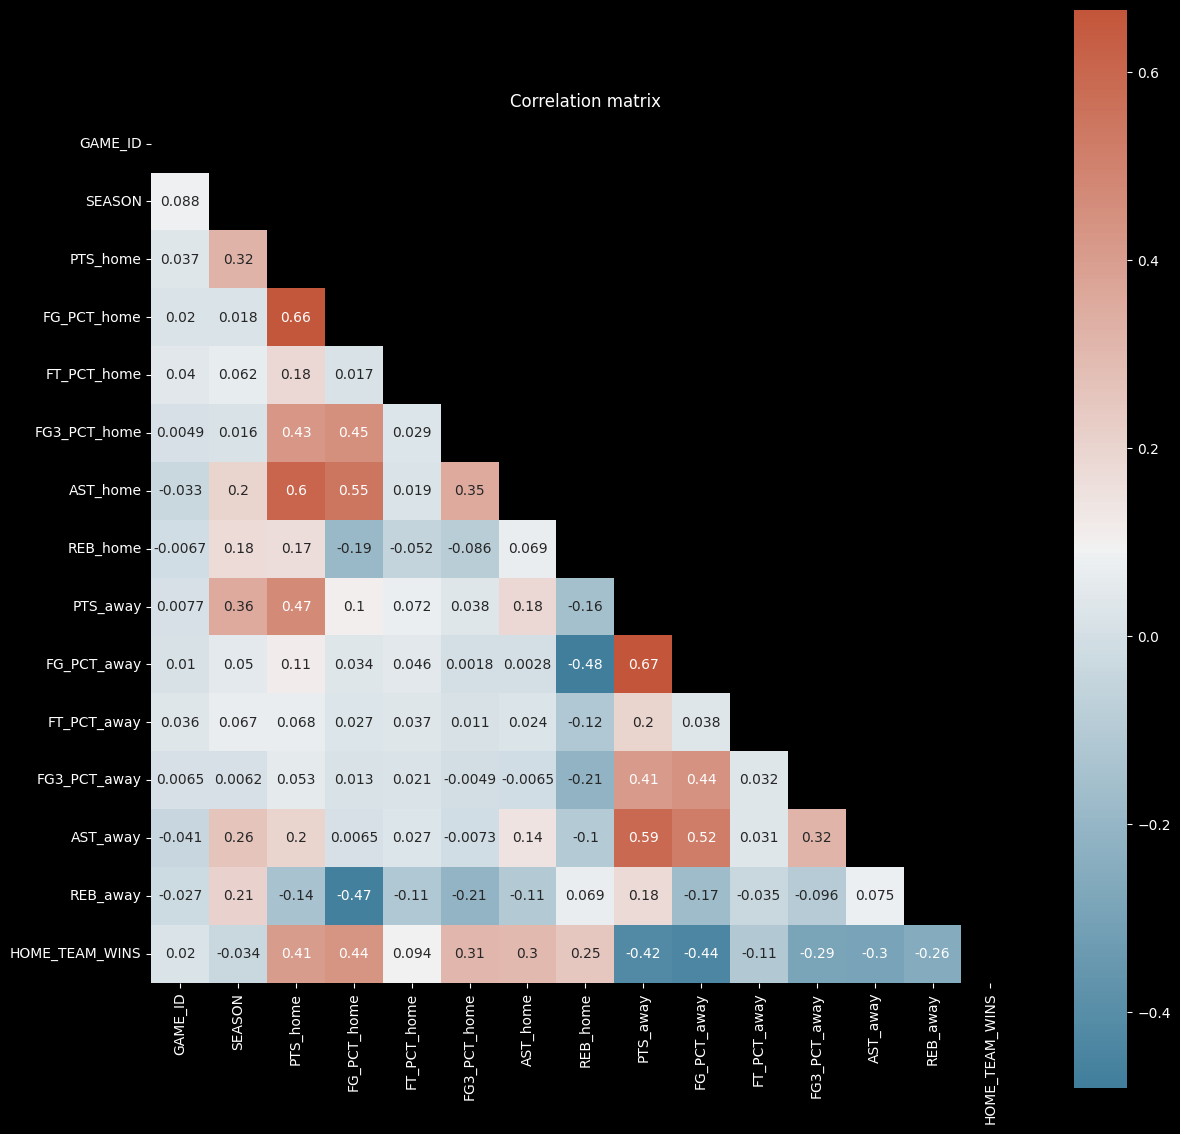

In [76]:
# 热力图
plt.figure(figsize=(14, 14))
plt.title('Correlation matrix')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), square=True, annot=True, cmap=cmap ,mask=mask)

PTS_home, FG_PCT_home, FG3_PCT_home和AST_home。  
PTS_away, FG_PCT_away, FG3_PCT_away和AST_away。  
这些变量是相互关联的，这是正常的，因为助攻越多，三分命中率越高，得分就越多。  
在预测模型中，变量'PTS_home'和'PTS_away'将被删除，因为如果知道具体两队的得分，就不需要预测球队是否获胜。  

In [77]:
# 对数据进行修改，将GAME_DATE_EST变为三个新变量
df['GAME_YEAR'] = pd.to_datetime(df['GAME_DATE_EST']).dt.year.apply(str)
df['GAME_MONTH'] = pd.to_datetime(df['GAME_DATE_EST']).dt.month.apply(str)
df['GAME_DAY'] = pd.to_datetime(df['GAME_DATE_EST']).dt.day.apply(str)
df['GAME_YEAR'] = pd.to_numeric(df['GAME_YEAR'])
df['GAME_MONTH'] = pd.to_numeric(df['GAME_MONTH'])
df['GAME_DAY'] = pd.to_numeric(df['GAME_DAY'])
df.drop(['GAME_DATE_EST'], axis=1, inplace=True)

c=['HOME_TEAM_ID','VISITOR_TEAM_ID']
for i in c:
    freq=df[i].value_counts().to_dict()
    df[i]=df[i].map(freq)

# 删除变量'PTS_home'和'PTS_away'
df.drop(['PTS_home', 'PTS_away'], axis=1, inplace=True)
# # 删除重复行
# df = df.drop_duplicates(subset=['GAME_ID'], ignore_index=False)
# df = df.set_index('GAME_ID')

df.head()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,GAME_YEAR,GAME_MONTH,GAME_DAY
0,22101005,870,767,2021,0.398,0.760,0.333,23.0,53.0,0.422,0.875,0.357,21.0,46.0,0,2022,3,12
1,22101009,803,812,2021,0.551,0.750,0.407,32.0,39.0,0.471,0.760,0.387,28.0,50.0,0,2022,3,12
2,22101011,805,820,2021,0.516,0.909,0.367,21.0,43.0,0.470,0.963,0.412,26.0,35.0,1,2022,3,12
3,22101010,799,782,2021,0.558,0.710,0.390,21.0,44.0,0.500,0.857,0.394,27.0,33.0,1,2022,3,12
4,22101006,829,825,2021,0.443,0.933,0.429,20.0,46.0,0.419,0.824,0.208,19.0,40.0,1,2022,3,12


# 预测模型

将数据分割为80%:20%，完成训练集数据的分割，实际测试集数据用真实数据。  

### 输入变量
| 变量名 | 注释 |
| :-: | :-: |
| GAME_DATE_EST | 比赛日期 |
| GAME_ID | 比赛ID |
| GAME_STATUS_TEXT | 比赛状态(“Final”，表示比赛已经完成) |
| HOME_TEAM_ID | 主队ID |
| VISITOR_TEAM_ID | 客队ID |
| SEASON | 赛季 |
| TEAM_ID_home | 主队ID |
| PTS_home | 主队得分的数量 |
| FG_PCT_home | 主队的有效投篮率 |
| FT_PCT_home | 主队的有效罚球率 |
| FG3_PCT_home | 主队三分命中率 |
| AST_home | 主队助攻 |
| REB_home | 主队篮板 |
| TEAM_ID_away | 客队ID |
| PTS_away | 客队得分的点数 |
| FG_PCT_away | 客队的有效投篮率 |
| FT_PCT_away | 客队罚球的有效百分比 |
| FG3_PCT_away | 客队三分命中率 |
| AST_away | 客队助攻 |
| REB_away | 客队篮板 |

### 目标变量
| 变量名 | 注释 |
| :-: | :-: |
| HOME_TEAM_WINS | 如果主队赢了比赛(1)，如果没有赢(0) |

In [78]:
# 实际测试数据
_df = df[df['SEASON'] == 2021]
print('real test:', _df.shape)
# 训练数据
df = df[(df['SEASON'] >= 2004) & (df['SEASON'] <= 2020)]
print('train:',df.shape)

# 训练数据集分割（0.8 : 0.2）
X = df.drop(['HOME_TEAM_WINS'], axis=1)
Y = df['HOME_TEAM_WINS']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# 实际测试集数据
X_real = _df.drop(['HOME_TEAM_WINS'], axis=1)
Y_real = _df['HOME_TEAM_WINS']

real test: (1076, 18)
train: (23335, 18)


In [79]:
# 可视化混淆矩阵生成函数
def to_plot_confusion_matrix(modelo):
    disp = plot_confusion_matrix(modelo, X_train, Y_train,
                               cmap=plt.cm.BuPu, values_format='d')
    true_pred = disp.confusion_matrix[0,0]+disp.confusion_matrix[1,1]
    total_data = np.sum(disp.confusion_matrix)
    accuracy = true_pred/total_data
    plt.show()

## LogisticRegression

LogisticRegression in Train accuracy: 0.5886543818298693
LogisticRegression in Test accuracy: 0.5933147632311978
LogisticRegression in RealTest accuracy: 0.5548327137546468


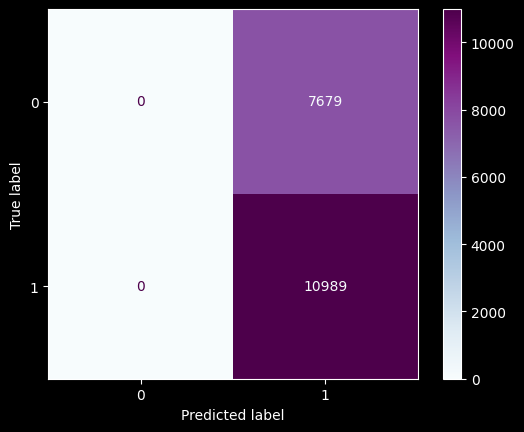

In [80]:
lr = LogisticRegression(C=2, n_jobs=2, solver='liblinear', penalty='l2')
lr.fit(X_train, Y_train)
print('LogisticRegression in Train accuracy:', lr.score(X_train, Y_train))
print('LogisticRegression in Test accuracy:', lr.score(X_test, Y_test))
print('LogisticRegression in RealTest accuracy:', lr.score(X_real, Y_real))
to_plot_confusion_matrix(lr)

## DecisionTreeClassifier

DecisionTreeClassifier in Train accuracy: 1.0
DecisionTreeClassifier in Test accuracy: 0.7647310906363831
DecisionTreeClassifier in RealTest accuracy: 0.7871747211895911


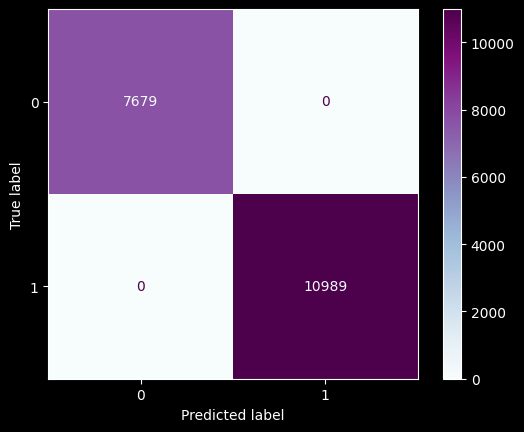

In [81]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
print('DecisionTreeClassifier in Train accuracy:', dtc.score(X_train, Y_train))
print('DecisionTreeClassifier in Test accuracy:', dtc.score(X_test, Y_test))
print('DecisionTreeClassifier in RealTest accuracy:', dtc.score(X_real, Y_real))
to_plot_confusion_matrix(dtc)

## KNeighborsClassifier

K-Nearest Neighbours in Train accuracy: 0.7343046925219627
K-Nearest Neighbours in Test accuracy: 0.5778872937647311
K-Nearest Neighbours in RealTest accuracy: 0.5548327137546468


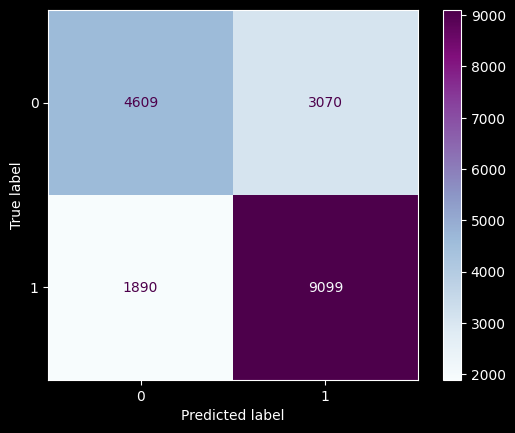

In [82]:
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, Y_train)
print('K-Nearest Neighbours in Train accuracy:', knn.score(X_train, Y_train))
print('K-Nearest Neighbours in Test accuracy:', knn.score(X_test, Y_test))
print('K-Nearest Neighbours in RealTest accuracy:', knn.score(X_real, Y_real))
to_plot_confusion_matrix(knn)

## Naive Bayes

Naive Bayes in Train accuracy: 0.5835118920077137
Naive Bayes in Test accuracy: 0.5862438397257339
Naive Bayes in RealTest accuracy: 0.6942379182156134


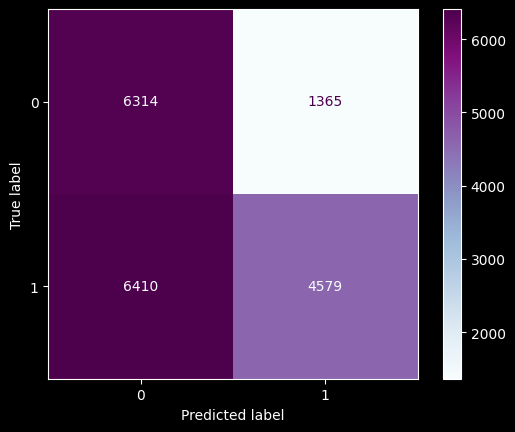

In [83]:
mnb = MultinomialNB()
mnb.fit(X_train, Y_train)
print('Naive Bayes in Train accuracy:', mnb.score(X_train, Y_train))
print('Naive Bayes in Test accuracy:', mnb.score(X_test, Y_test))
print('Naive Bayes in RealTest accuracy:', mnb.score(X_real, Y_real))
to_plot_confusion_matrix(mnb)

## RandomForestClassifier

RandomForestClassifier in Train accuracy: 0.8311013499035783
RandomForestClassifier in Test accuracy: 0.7990143561174202
RandomForestClassifier in RealTest accuracy: 0.8262081784386617


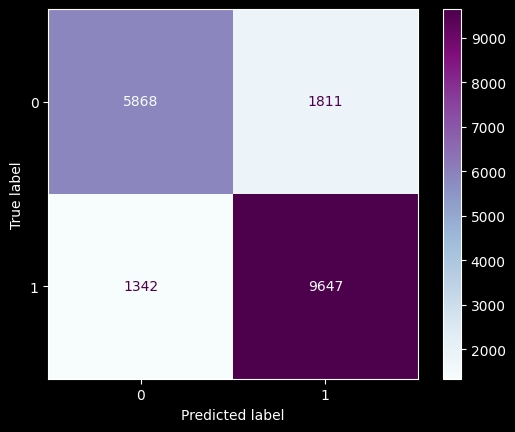

In [84]:
rf = RandomForestClassifier(n_estimators=3,  max_depth=7)
rf.fit(X_train, Y_train)
print('RandomForestClassifier in Train accuracy:', rf.score(X_train, Y_train))
print('RandomForestClassifier in Test accuracy:', rf.score(X_test, Y_test))
print('RandomForestClassifier in RealTest accuracy:', rf.score(X_real, Y_real))
to_plot_confusion_matrix(rf)

## SVC

SVC in Train accuracy: 1.0
SVC in Test accuracy: 0.5896721662738376
SVC in RealTest accuracy: 0.5548327137546468


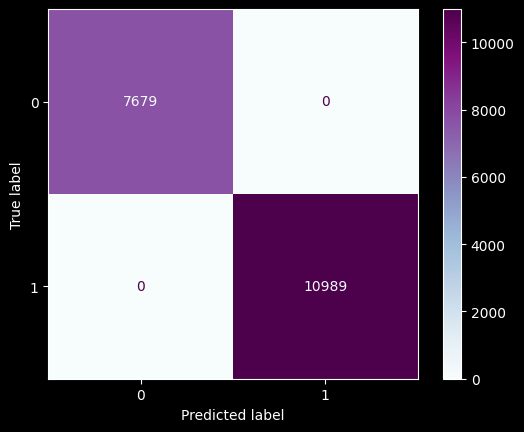

In [85]:
clf = SVC(C=10,gamma=0.01,kernel='rbf')
clf.fit(X_train, Y_train)
print('SVC in Train accuracy:', clf.score(X_train, Y_train))
print('SVC in Test accuracy:', clf.score(X_test, Y_test))
print('SVC in RealTest accuracy:', clf.score(X_real, Y_real))
to_plot_confusion_matrix(clf)

In [86]:
# Y_pred = clf.predict(X_test) 
# print('balanced accuracy score:', balanced_accuracy_score(Y_test, Y_pred)) 
# # fine-tuning hyperparameters
# scoring = make_scorer(balanced_accuracy_score)
# param_grid = {'C': [0.1, 1, 10],  
#               'gamma': [1,0.1,0.01]}
# grid = GridSearchCV(SVC(kernel='rbf'), param_grid, scoring = scoring, refit=True, verbose=2) 
# grid.fit(X_train, Y_train)
# # print the best model's hyperparameters
# Dis = grid.best_estimator_
# print(Dis)

In [87]:
# print('grid in Train accuracy:', grid.score(X_train, Y_train))
# print('grid in Test accuracy:', grid.score(X_test, Y_test))
# print('grid in RealTest accuracy:', grid.score(X_real, Y_real))
# to_plot_confusion_matrix(grid)

## ROC曲线

Text(0.5, 1.0, 'Test data ROC')

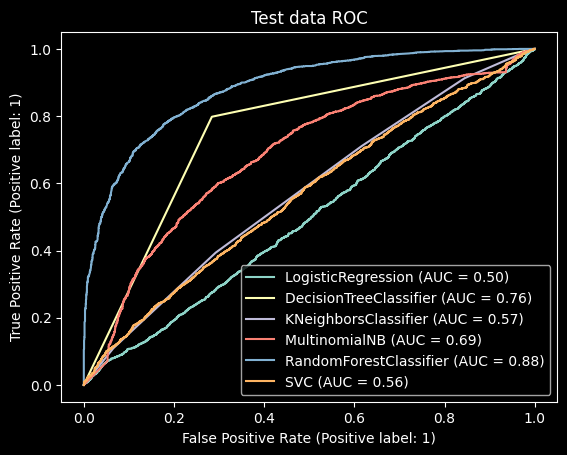

In [88]:
disp = plot_roc_curve(lr, X_test, Y_test)
plot_roc_curve(dtc, X_test, Y_test, ax = disp.ax_)
plot_roc_curve(knn, X_test, Y_test, ax = disp.ax_)
plot_roc_curve(mnb, X_test, Y_test, ax = disp.ax_)
plot_roc_curve(rf, X_test, Y_test, ax = disp.ax_)
plot_roc_curve(clf, X_test, Y_test, ax = disp.ax_)
plt.title('Test data ROC')

Text(0.5, 1.0, 'Real data ROC')

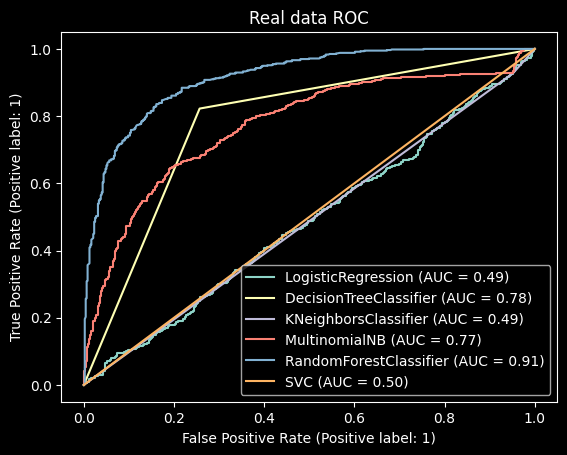

In [89]:
disp = plot_roc_curve(lr, X_real, Y_real)
plot_roc_curve(dtc, X_real, Y_real, ax = disp.ax_)
plot_roc_curve(knn, X_real, Y_real, ax = disp.ax_)
plot_roc_curve(mnb, X_real, Y_real, ax = disp.ax_)
plot_roc_curve(rf, X_real, Y_real, ax = disp.ax_)
plot_roc_curve(clf, X_real, Y_real, ax = disp.ax_)
plt.title('Real data ROC')